In [2]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from ObjectDetection.data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from torchvision import transforms, models

import time
import copy

In [3]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)


In [3]:
train_label = np.arange(106, 124)
val_label = np.arange(125, 130)
test_label = np.arange(131, 134)

In [23]:
BATCH_SIZE= 1
transform = torchvision.transforms.Compose([
    # transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    # transforms.Normalize(img_net_mean.tolist(), img_net_std.tolist())
])

labeled_trainset = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = train_label,
                                  transform = transform, 
                                  extra_info = True)
labeled_valset = LabeledDataset(image_folder=  image_folder, 
                                annotation_file = annotation_csv, 
                                scene_index = val_label, 
                                transform = transform, 
                                extra_info = True)
labeled_testset = LabeledDataset(image_folder =  image_folder, 
                                annotation_file = annotation_csv, 
                                scene_index = test_label, 
                                transform = transform, 
                                extra_info = True)

# labeled_trainset = LabeledDataset(image_folder = image_folder,
#                                   annotation_file = annotation_csv,
#                                   scene_index = labeled_scene_index,
#                                   transform = transform, 
#                                   extra_info = True)

train_set, val_set, test_set = torch.utils.data.random_split(labeled_trainset, [2646, 441, 441])
# train_set, val_set = torch.utils.data.random_split(labeled_trainset, [2646, 882])
mini_set, _ = torch.utils.data.random_split(labeled_trainset, [3, len(labeled_trainset) - 3])

train_loader = torch.utils.data.DataLoader(train_set, batch_size =BATCH_SIZE, 
                                           shuffle = True, num_workers =2, 
                                           collate_fn = collate_fn)

# val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=BATCH_SIZE,
#                                         shuffle= True, num_workers =2,
#                                         collate_fn = collate_fn)
mini_loader = torch.utils.data.DataLoader(mini_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

#test_loader = torch.utils.data.DataLoader(labeled_testset, batch_size = BATCH_SIZE, 
#                                        shuffle = True, num_workers = 2,
#                                        collate_fn = collate_fn)



In [71]:
class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers, out_activation = 'relu'):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)
    
class _SameDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, out_activation = 'relu'):
        super(_SameDecoder, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=3),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        layers += [
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)

In [72]:
# pyramid style decoder:
class PPMBilinear(nn.Module):
    def __init__(self, num_class=1, fc_dim=256,
                 pool_scales=(1, 2, 3, 6), out_size=800):
        super(PPMBilinear, self).__init__()
        self.out_size = out_size
        self.ppm = [nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                    nn.Conv2d(fc_dim, 256, kernel_size=1, bias= False), 
                    nn.ReLU(inplace=True))]
        for scale in pool_scales[1:]:
            self.ppm.append(nn.Sequential(nn.AdaptiveAvgPool2d(scale), 
                            nn.Conv2d(fc_dim, 256, kernel_size=1, bias= False), 
                            nn.BatchNorm2d(256), 
                            nn.ReLU(inplace=True)))
        self.ppm = nn.ModuleList(self.ppm)

        self.pool_conv = nn.Sequential(
            nn.Conv2d(fc_dim+len(pool_scales)*256, 256,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            # nn.Conv2d(512, num_class, kernel_size=1)
        )
        self.conv_last = nn.Sequential(*[_SameDecoder(256, 256), 
                                         _DecoderBlock(256, 128, 2),
                                         _DecoderBlock(128, 64, 2), 
                                         _DecoderBlock(64, 32, 2), 
                                         _DecoderBlock(32, 1, 2, 'Sigmoid')])
        
        # self.sigmoid = nn.Sigmoid()
    def forward(self, conv_out):
        conv5 = conv_out[-1]

        input_size = conv5.size()
             
        ppm_out = [conv5]
        for pool_scale in self.ppm:
            ppm_out.append(nn.functional.interpolate(
                pool_scale(conv5),
                (input_size[2], input_size[3]),
                mode='bilinear', align_corners=False))
        ppm_out = torch.cat(ppm_out, 1)
        print(ppm_out.shape)
        x = self.pool_conv(ppm_out)
        #feat = x
        x  =self.conv_last(x)
        print(x.shape)
        x = nn.functional.interpolate(x, (self.out_size,self.out_size), mode='bilinear', align_corners = False)
        
        return x

In [73]:
class TransformModule(nn.Module):
    def __init__(self, dim1, dim2, num_view = 6):
        super(TransformModule, self).__init__()
        self.num_view = num_view
        self.dim1 = dim1
        self.dim2 = dim2
        self.mat_list = nn.ModuleList()
        
        for i in range(self.num_view):
            # weights are not shared
            fc_transform = nn.Sequential(
                        nn.Linear(dim1* dim2, dim1*dim2), 
                        nn.ReLU(), 
                        nn.Linear(dim1 * dim2, dim1*dim2),
                        nn.ReLU()
            )
            self.mat_list += [fc_transform]
    
    def forward(self, x):
        # shape B V C H W
        # flatten along the channel
        x = x.view(list(x.size()[:3]) + [self.dim1 * self.dim2,])
        # Transform the first image
        view_comb = self.mat_list[0](x[:, 0])
        for i in range(1, x.size(1)):
            # results are added(fusion func)
            view_comb += self.mat_list[i](x[:, i])
        view_comb = view_comb.view(list(view_comb.size()[:2]) + [self.dim1, self.dim2]) 
        return view_comb
        

class vpn_model(nn.Module):
    def __init__(self, dim1, dim2, encoder, decoder):
        super(vpn_model, self).__init__()
        self.num_views = 6
        self.encoder = encoder
        
        self.transform = TransformModule(dim1=dim1, dim2=dim2)
        
        self.decoder = decoder
        
        
    def forward(self, x, return_feat = False):
        # flatten the output along channel: C x (HW)
        # weights are not shared, i.e. each first view input has
        # own VRM to get its top down view feature map 
        # i here in range 6(MN, N=6,M=1(MODALITY))
        # j here in range num_channels
        # 
        B,V,C,H,W = x.shape
        x = x.view(B*V, C, H, W)
        x = self.encoder(x)
        # return to B V 
        x = x.view([B,V] + list(x.size()[1:]))
        x =  self.transform(x) # B x c x h x w
        
#         if return_feat:
#             x, feat = self.decoder([x])
#         else:
#             x = self.decoder([x])
        x = self.decoder([x])

        return x

In [74]:
def dice_loss(true, preds, epsilon = 1e-4):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

def dice_loss2(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)


def compute_dice(true, preds, epsilon = 1e-7):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

In [75]:
sample = torch.rand((3, 6, 3, 256, 306))

In [76]:
temp_encoder = torchvision.models.resnet18(pretrained = False)
temp_encoder = list(temp_encoder.children())[:-3]
temp_encoder = nn.Sequential(*temp_encoder)
for param in temp_encoder.parameters():
    param.requires_grad = True

In [77]:
temp_decoder = PPMBilinear(fc_dim=256)

In [78]:
temp_model = vpn_model(16, 20, temp_encoder, temp_decoder)

In [79]:
sample.shape

torch.Size([3, 6, 3, 256, 306])

In [80]:
temp_output = temp_model(sample)

torch.Size([3, 1280, 16, 20])
torch.Size([3, 1, 768, 960])


In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# final average pool layer and last residual layer is removed to better preserve the resolutions
resnet_encoder = torchvision.models.resnet18(pretrained = False)
resnet_encoder = list(resnet_encoder.children())[:-3]
resnet_encoder = nn.Sequential(*resnet_encoder)
for param in resnet_encoder.parameters():
    param.requires_grad = True
resnet_encoder = resnet_encoder.to(device)
# result produced by this encoder is B x 256 x 16 x 20(from 256 x 306)

In [27]:
DIM1 = 16
DIM2 = 20
decoder = PPMBilinear(fc_dim=256)
my_model = vpn_model(DIM1, DIM2, resnet_encoder, decoder).to(device)

In [28]:
sample, _ ,roadmap, _ = iter(mini_loader).next()

In [29]:
sample = torch.stack(sample).to(device)
target = torch.stack(roadmap).to(device)

In [54]:
test_output = my_model(sample)


In [55]:
test_output.shape

torch.Size([1, 1, 800, 800])

In [56]:
print('dice loss', dice_loss2(target.cpu(), test_output.cpu().squeeze(1)))

dice loss tensor(0.5445, grad_fn=<RsubBackward1>)


In [10]:
def train_model(model, dataloader, criterion, optimizer, num_epochs,print_every=10):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    
    dice_dict={'train':[], 'eval':[]}
    loss_dict = {'train':[], 'eval':[]}
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        
        for phase in ['train']:
            
            model.train()
            curr_loss = 0.0
            curr_dice = 0.0
            
            for i, (sample, target, roadmap, extra) in enumerate(dataloader):
                
                #target = torch.rot90(roadmap[0].int(), 1, [0,1]).type(torch.LongTensor).to(device)
                target = torch.stack(roadmap).type(torch.LongTensor).to(device)
                inputs = torch.stack(sample).type(torch.FloatTensor).to(device)
                # print('the target size is ', target.shape)
                # print('the inputs size is ', inputs.shape)
                # print('the input size is ', inputs.shape)
            
     
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    output = model(inputs)
                    loss = criterion(target.cpu(), output.cpu().squeeze(1))

                    loss.backward()
                    optimizer.step()
                with torch.no_grad():
                    dice_score = compute_dice(target.cpu(), output.cpu().squeeze(1))

                curr_loss += loss.item()
                curr_dice += dice_score
                
            # After 1 epoch record the loss
            
            
            
            
            loss_dict['train'].append(curr_loss/len(dataloader))
            dice_dict['train'].append(curr_dice/len(dataloader))

            print('current epoch dice loss is', curr_loss)
            print('current epoch dice is ', curr_dice)
            print('Training 1 epoch takes ', time.time() - epoch_start)
            
        if epoch %print_every == 0:
            fig, ax = plt.subplots(5, 2, figsize=(15,30))
            test_idx = [123, 592, 419, 322, 44]
            for fig_i, i in enumerate(test_idx):
                inputs = labeled_valset[i][0].unsqueeze(0).to(device)

                outputs = model(inputs).cpu().squeeze().detach()

                ax[fig_i, 0].imshow(labeled_valset[i][2].cpu().numpy())

                ax[fig_i, 1].imshow((outputs>0.5).numpy())
            
    print('This training takes ', time.time() - start_time)
    
    fig = plt.figure()
    plt.plot(loss_dict['train'])
    plt.title('Loss per epoch')
    plt.show()
    
    fig = plt.figure()
    plt.plot(dice_dict['train'])
    plt.title('Dice per epoch')
    plt.show()
    
    return model, loss_dict, dice_dict
    
    
    

In [11]:
# final average pool layer and last residual layer is removed to better preserve the resolutions
resnet_encoder = torchvision.models.resnet18(pretrained = False)
resnet_encoder = list(resnet_encoder.children())[:-3]
resnet_encoder = nn.Sequential(*resnet_encoder)
for param in resnet_encoder.parameters():
    param.requires_grad = True
resnet_encoder = resnet_encoder.to(device)
# result produced by this encoder is B x 256 x 16 x 20(from 256 x 306)

In [12]:
DIM1 = 16
DIM2 = 20
decoder = PPMBilinear(fc_dim=256)
my_model = vpn_model(DIM1, DIM2, resnet_encoder, decoder).to(device)

In [13]:
optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)

Epoch 1/50
----------
current epoch dice loss is 1.3899368047714233
current epoch dice is  tensor(0.8050)
Training 1 epoch takes  2.348097562789917
Epoch 2/50
----------
current epoch dice loss is 1.1792061924934387
current epoch dice is  tensor(0.9104)
Training 1 epoch takes  0.5261998176574707
Epoch 3/50
----------
current epoch dice loss is 1.1224895119667053
current epoch dice is  tensor(0.9388)
Training 1 epoch takes  0.4954261779785156
Epoch 4/50
----------
current epoch dice loss is 1.0989806056022644
current epoch dice is  tensor(0.9505)
Training 1 epoch takes  0.4628791809082031
Epoch 5/50
----------
current epoch dice loss is 1.0778876543045044
current epoch dice is  tensor(0.9611)
Training 1 epoch takes  0.46855998039245605
Epoch 6/50
----------
current epoch dice loss is 1.0694385170936584
current epoch dice is  tensor(0.9653)
Training 1 epoch takes  0.46323299407958984
Epoch 7/50
----------
current epoch dice loss is 1.0561697483062744
current epoch dice is  tensor(0.9719)

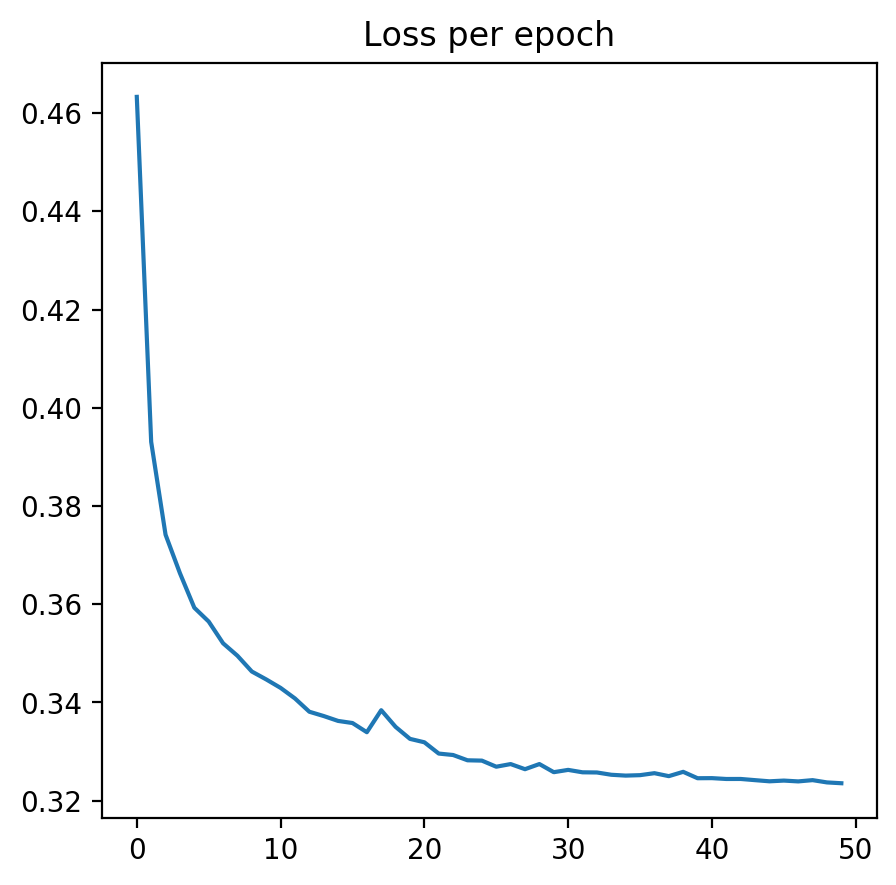

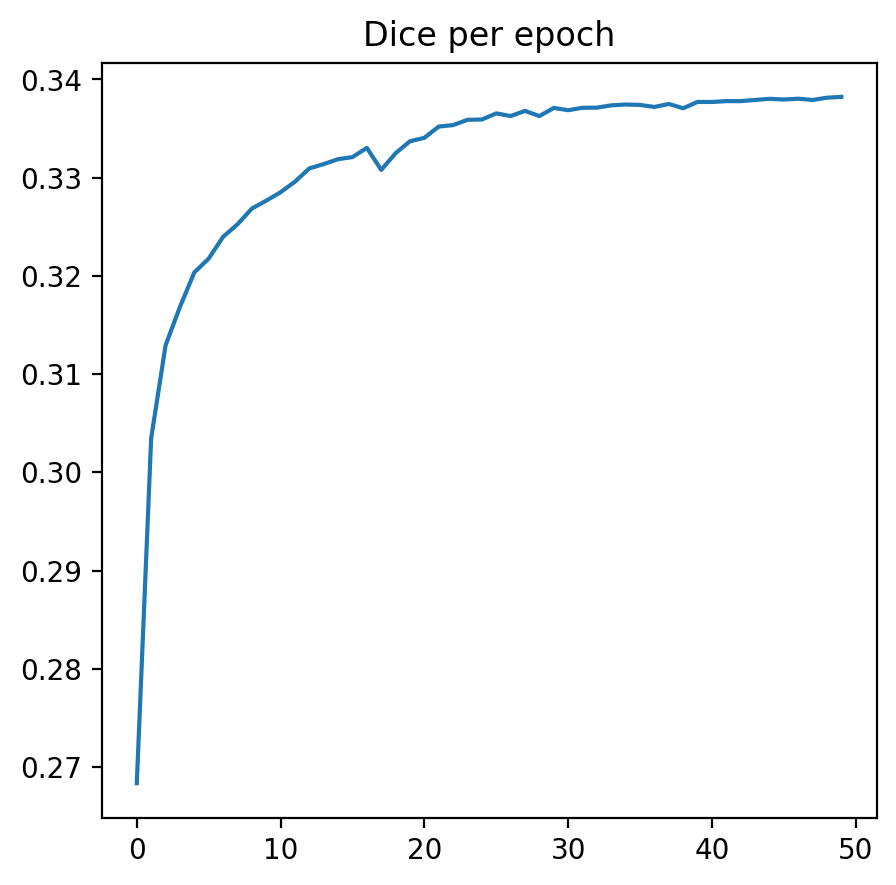

In [14]:
#mini loader to verify this is working
model, loss_dict, dice_dict = train_model(my_model, mini_loader, dice_loss, optimizer, 50)


Epoch 1/15
----------
current epoch dice loss is 826.9036773443222
current epoch dice is  tensor(720.5479)
Training 1 epoch takes  372.1647446155548
Epoch 2/15
----------
current epoch dice loss is 702.9654127955437
current epoch dice is  tensor(782.5175)
Training 1 epoch takes  370.7790229320526
Epoch 3/15
----------
current epoch dice loss is 612.200526714325
current epoch dice is  tensor(827.9006)
Training 1 epoch takes  371.5558068752289
Epoch 4/15
----------
current epoch dice loss is 535.9545086026192
current epoch dice is  tensor(866.0221)
Training 1 epoch takes  370.29824137687683
Epoch 5/15
----------
current epoch dice loss is 471.86919343471527
current epoch dice is  tensor(898.0655)
Training 1 epoch takes  375.29375553131104
Epoch 6/15
----------
current epoch dice loss is 415.40134155750275
current epoch dice is  tensor(926.2993)
Training 1 epoch takes  377.0566129684448
Epoch 7/15
----------
current epoch dice loss is 367.41918909549713
current epoch dice is  tensor(950.2

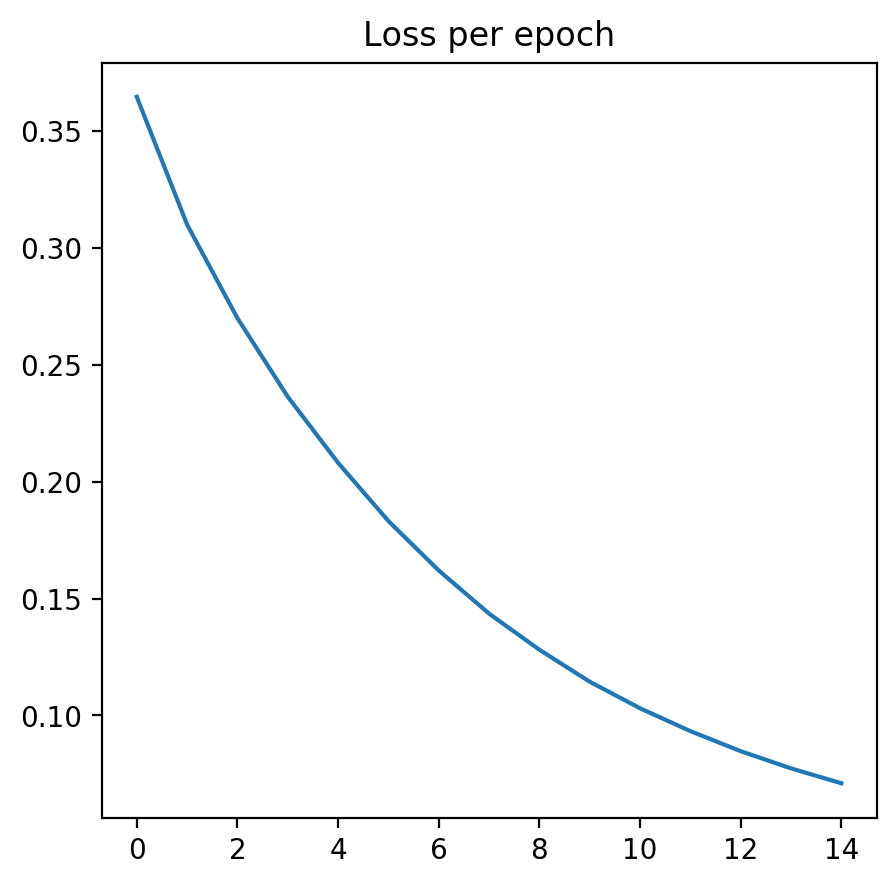

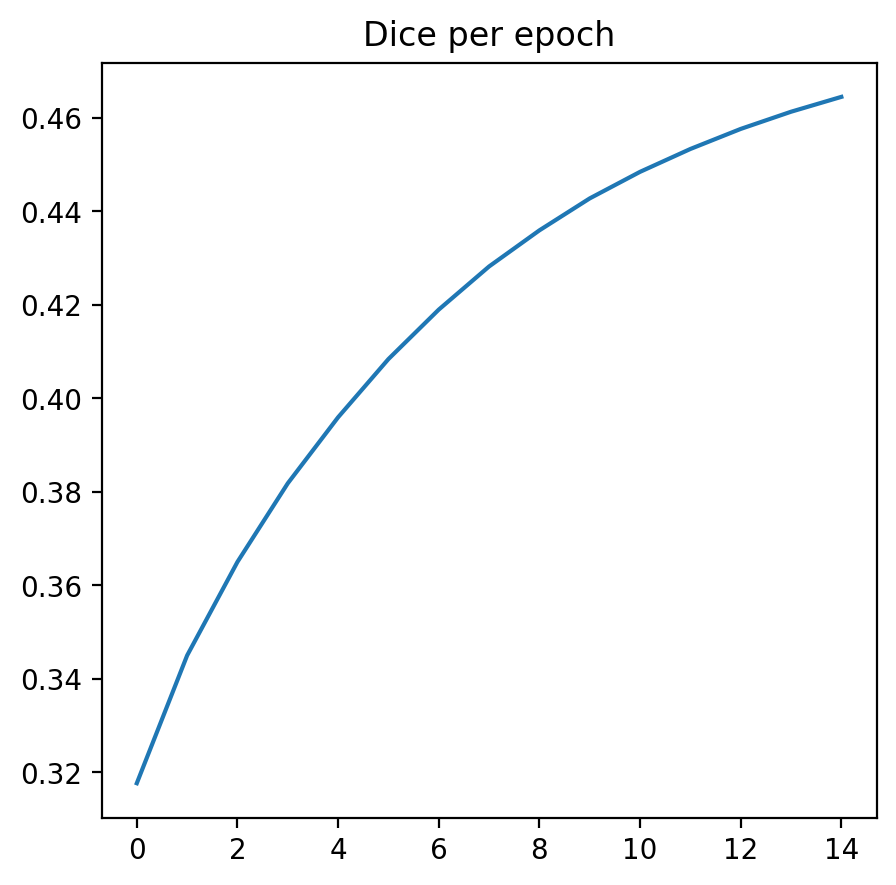

In [123]:
# final average pool layer and last residual layer is removed to better preserve the resolutions
resnet_encoder = torchvision.models.resnet18(pretrained = False)
resnet_encoder = list(resnet_encoder.children())[:-3]
resnet_encoder = nn.Sequential(*resnet_encoder)
for param in resnet_encoder.parameters():
    param.requires_grad = True
resnet_encoder = resnet_encoder.to(device)
# result produced by this encoder is B x 256 x 16 x 20(from 256 x 306)

DIM1 = 16
DIM2 = 20
decoder = PPMBilinear(fc_dim=256)
my_model = vpn_model(DIM1, DIM2, resnet_encoder, decoder).to(device)

optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)

model, loss_dict, dice_dict = train_model(my_model, train_loader, dice_loss, optimizer, 15)


Epoch 1/40
----------
current epoch dice loss is 825.9078816771507
current epoch dice is  tensor(721.0468)
Training 1 epoch takes  241.97985672950745
Epoch 2/40
----------
current epoch dice loss is 702.7446944713593
current epoch dice is  tensor(782.6273)
Training 1 epoch takes  241.22614860534668
Epoch 3/40
----------
current epoch dice loss is 610.6426103711128
current epoch dice is  tensor(828.6789)
Training 1 epoch takes  243.5880069732666
Epoch 4/40
----------
current epoch dice loss is 534.2920767068863
current epoch dice is  tensor(866.8547)
Training 1 epoch takes  246.59277367591858
Epoch 5/40
----------
current epoch dice loss is 469.0654873251915
current epoch dice is  tensor(899.4670)
Training 1 epoch takes  243.95493245124817
Epoch 6/40
----------
current epoch dice loss is 413.4823802113533
current epoch dice is  tensor(927.2586)
Training 1 epoch takes  244.83710527420044
Epoch 7/40
----------
current epoch dice loss is 365.196231842041
current epoch dice is  tensor(951.4

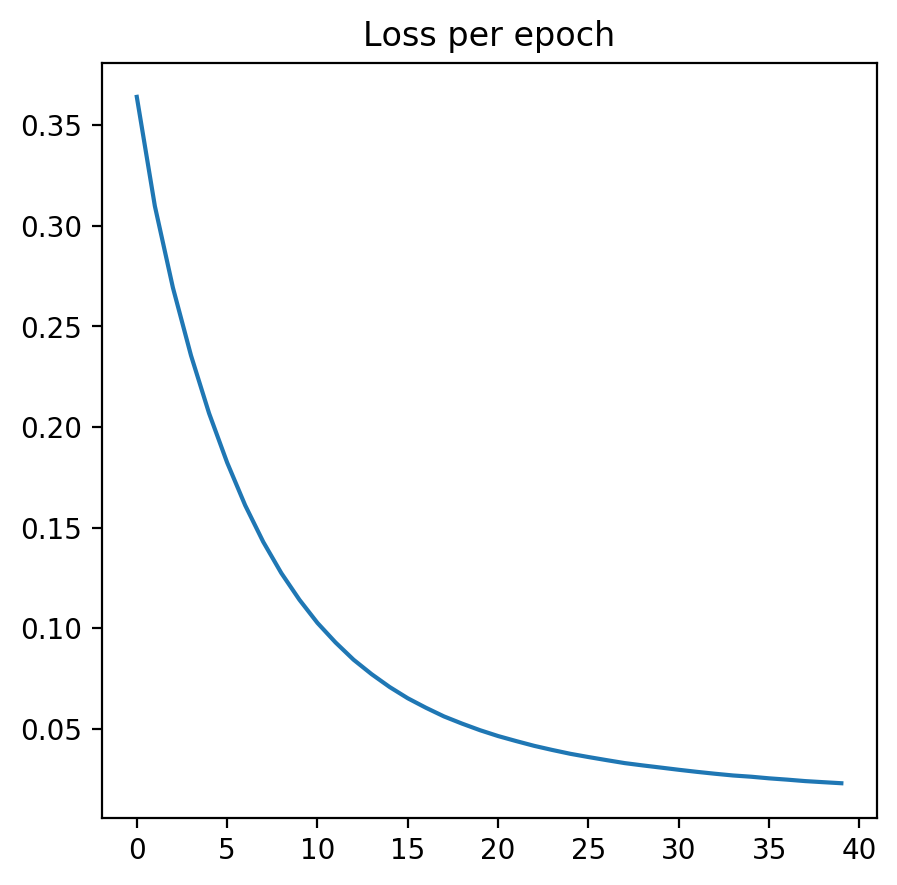

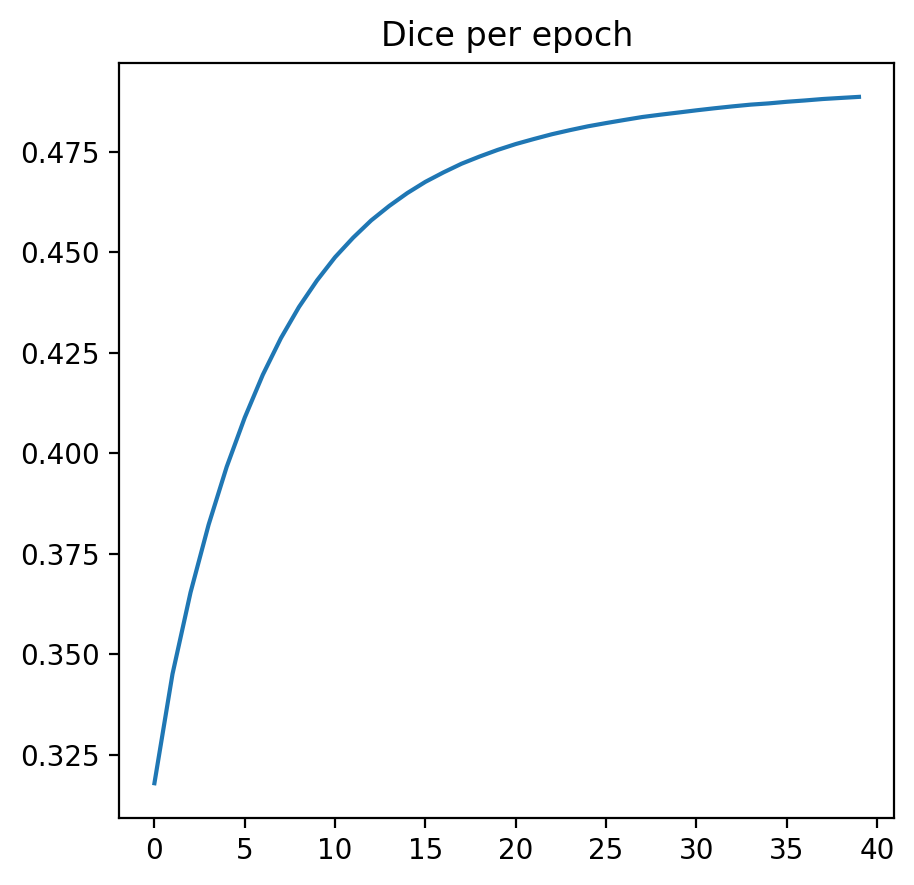

In [15]:
# final average pool layer and last residual layer is removed to better preserve the resolutions
resnet_encoder = torchvision.models.resnet18(pretrained = False)
resnet_encoder = list(resnet_encoder.children())[:-3]
resnet_encoder = nn.Sequential(*resnet_encoder)
for param in resnet_encoder.parameters():
    param.requires_grad = True
resnet_encoder = resnet_encoder.to(device)
# result produced by this encoder is B x 256 x 16 x 20(from 256 x 306)

DIM1 = 16
DIM2 = 20
decoder = PPMBilinear(fc_dim=256)
my_model = vpn_model(DIM1, DIM2, resnet_encoder, decoder).to(device)

optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)

model, loss_dict, dice_dict = train_model(my_model, train_loader, dice_loss, optimizer, 40)


In [18]:
torch.save(resnet_encoder.state_dict(), '/scratch/ht1162/DLSP20Dataset/resnet_encoder.pth')
torch.save(model.state_dict(), '/scratch/ht1162/DLSP20Dataset/res18_vpn2.pth')
torch.save(decoder.state_dict(), '/scratch/ht1162/DLSP20Dataset/ppm_decoder.pth')


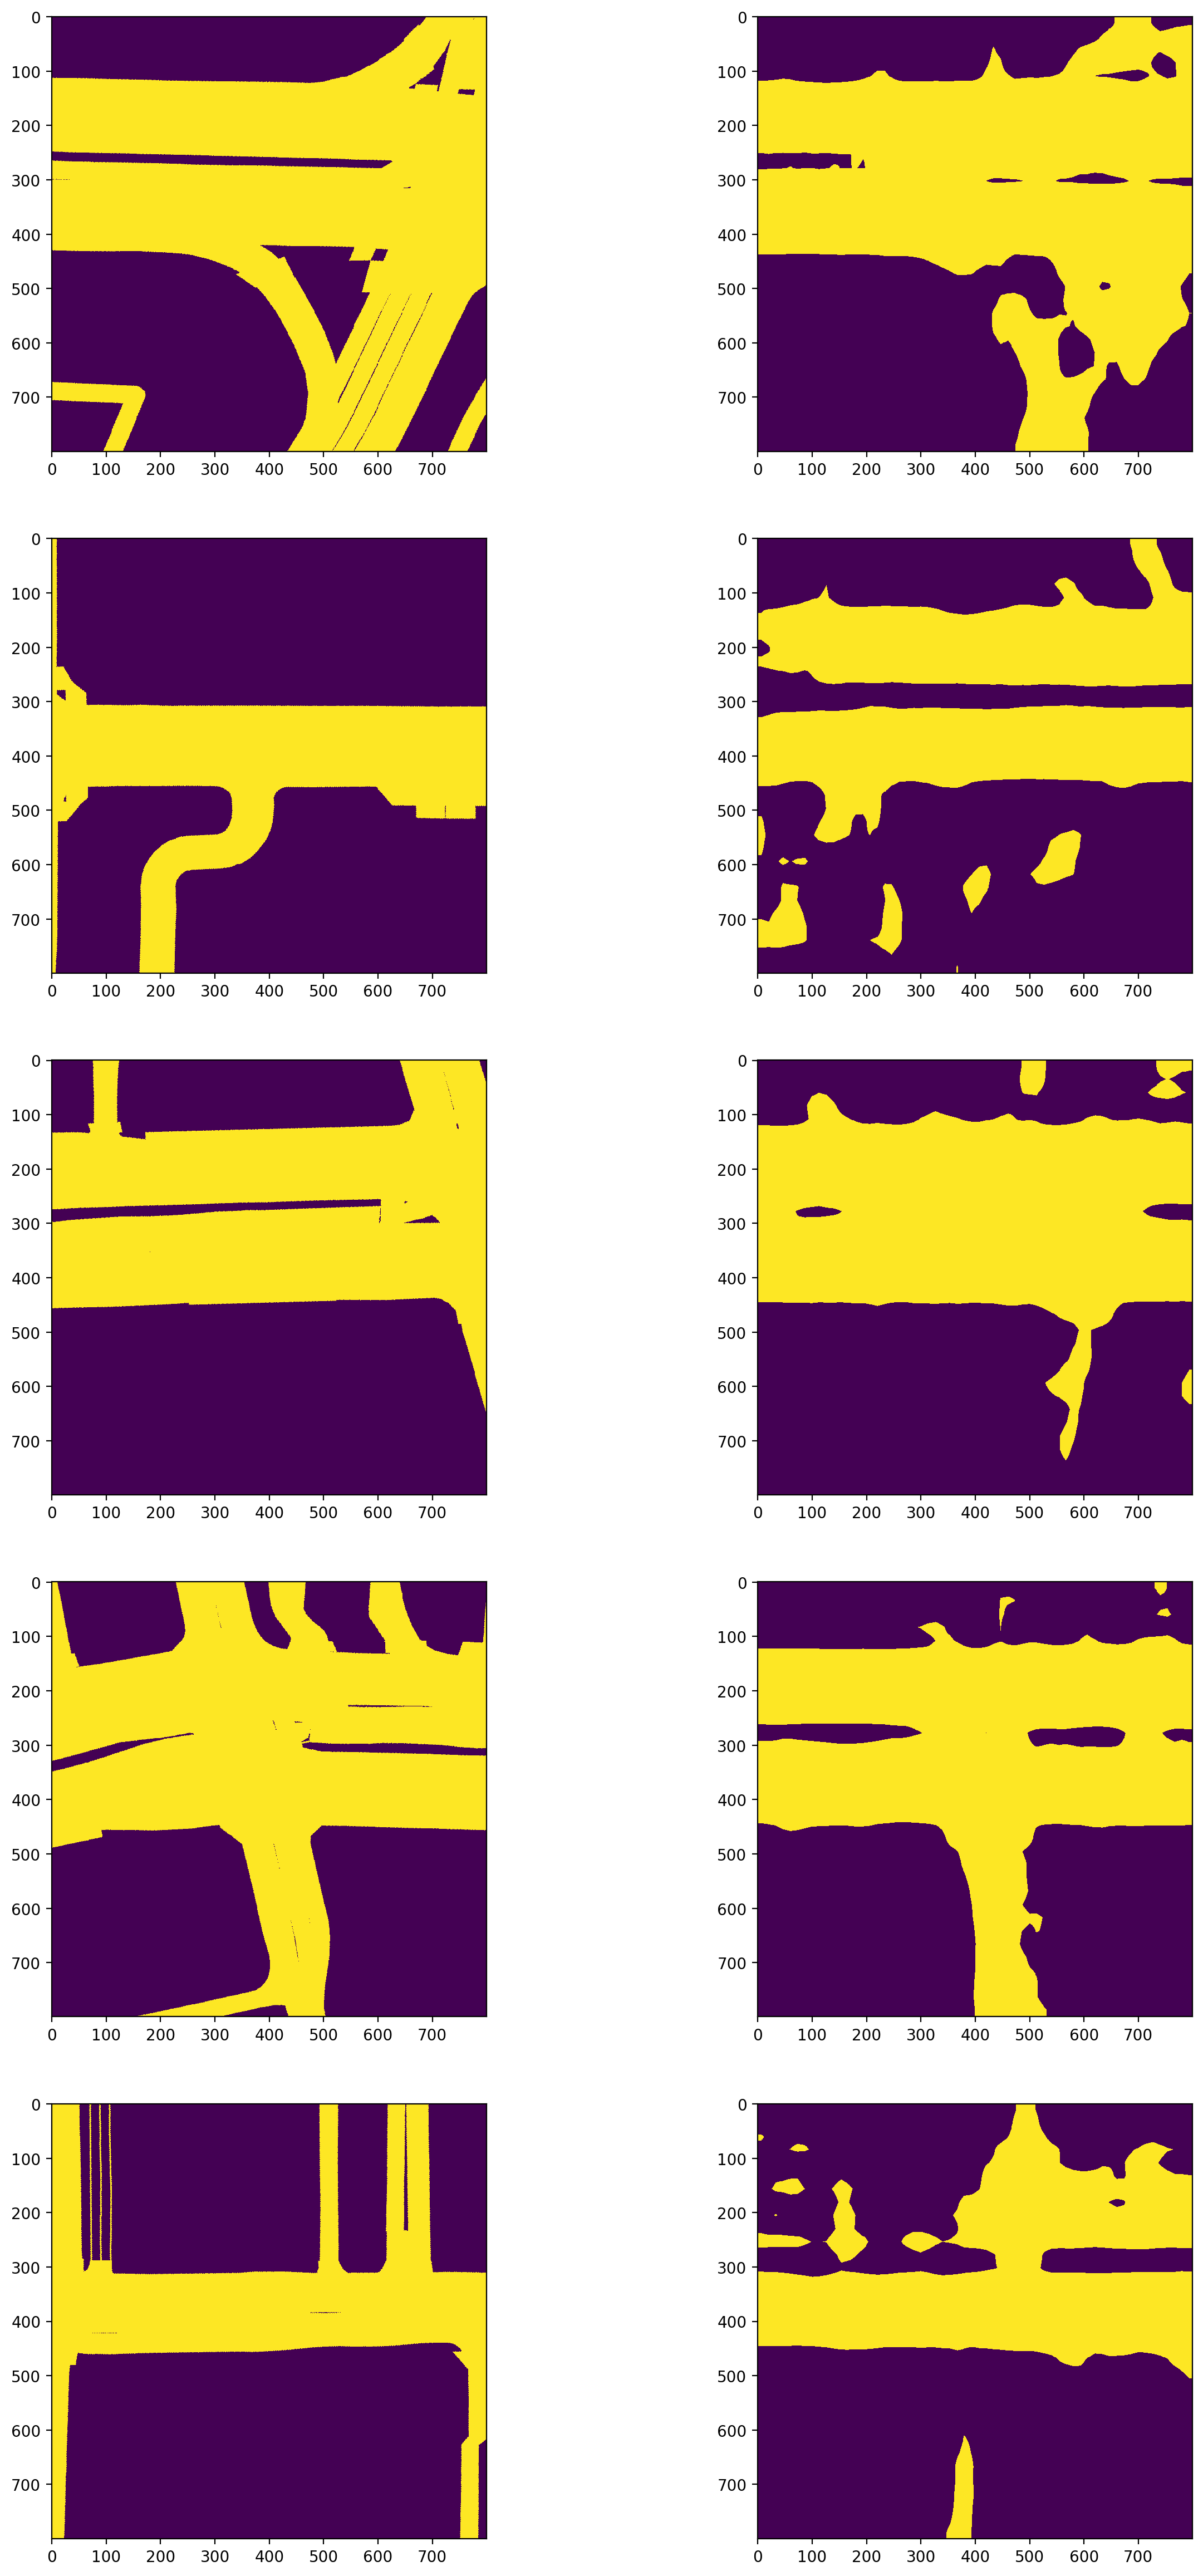

In [20]:
# This is the result after training for 40 epochs

fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [452,173, 254, 555,222]
for fig_i, i in enumerate(test_idx):
    inputs = labeled_valset[i][0].unsqueeze(0).to(device)
    
    outputs = model(inputs).cpu().squeeze().detach()
        
    ax[fig_i, 0].imshow(labeled_valset[i][2].cpu().numpy())
    
    ax[fig_i, 1].imshow((outputs>0.5).numpy())
    

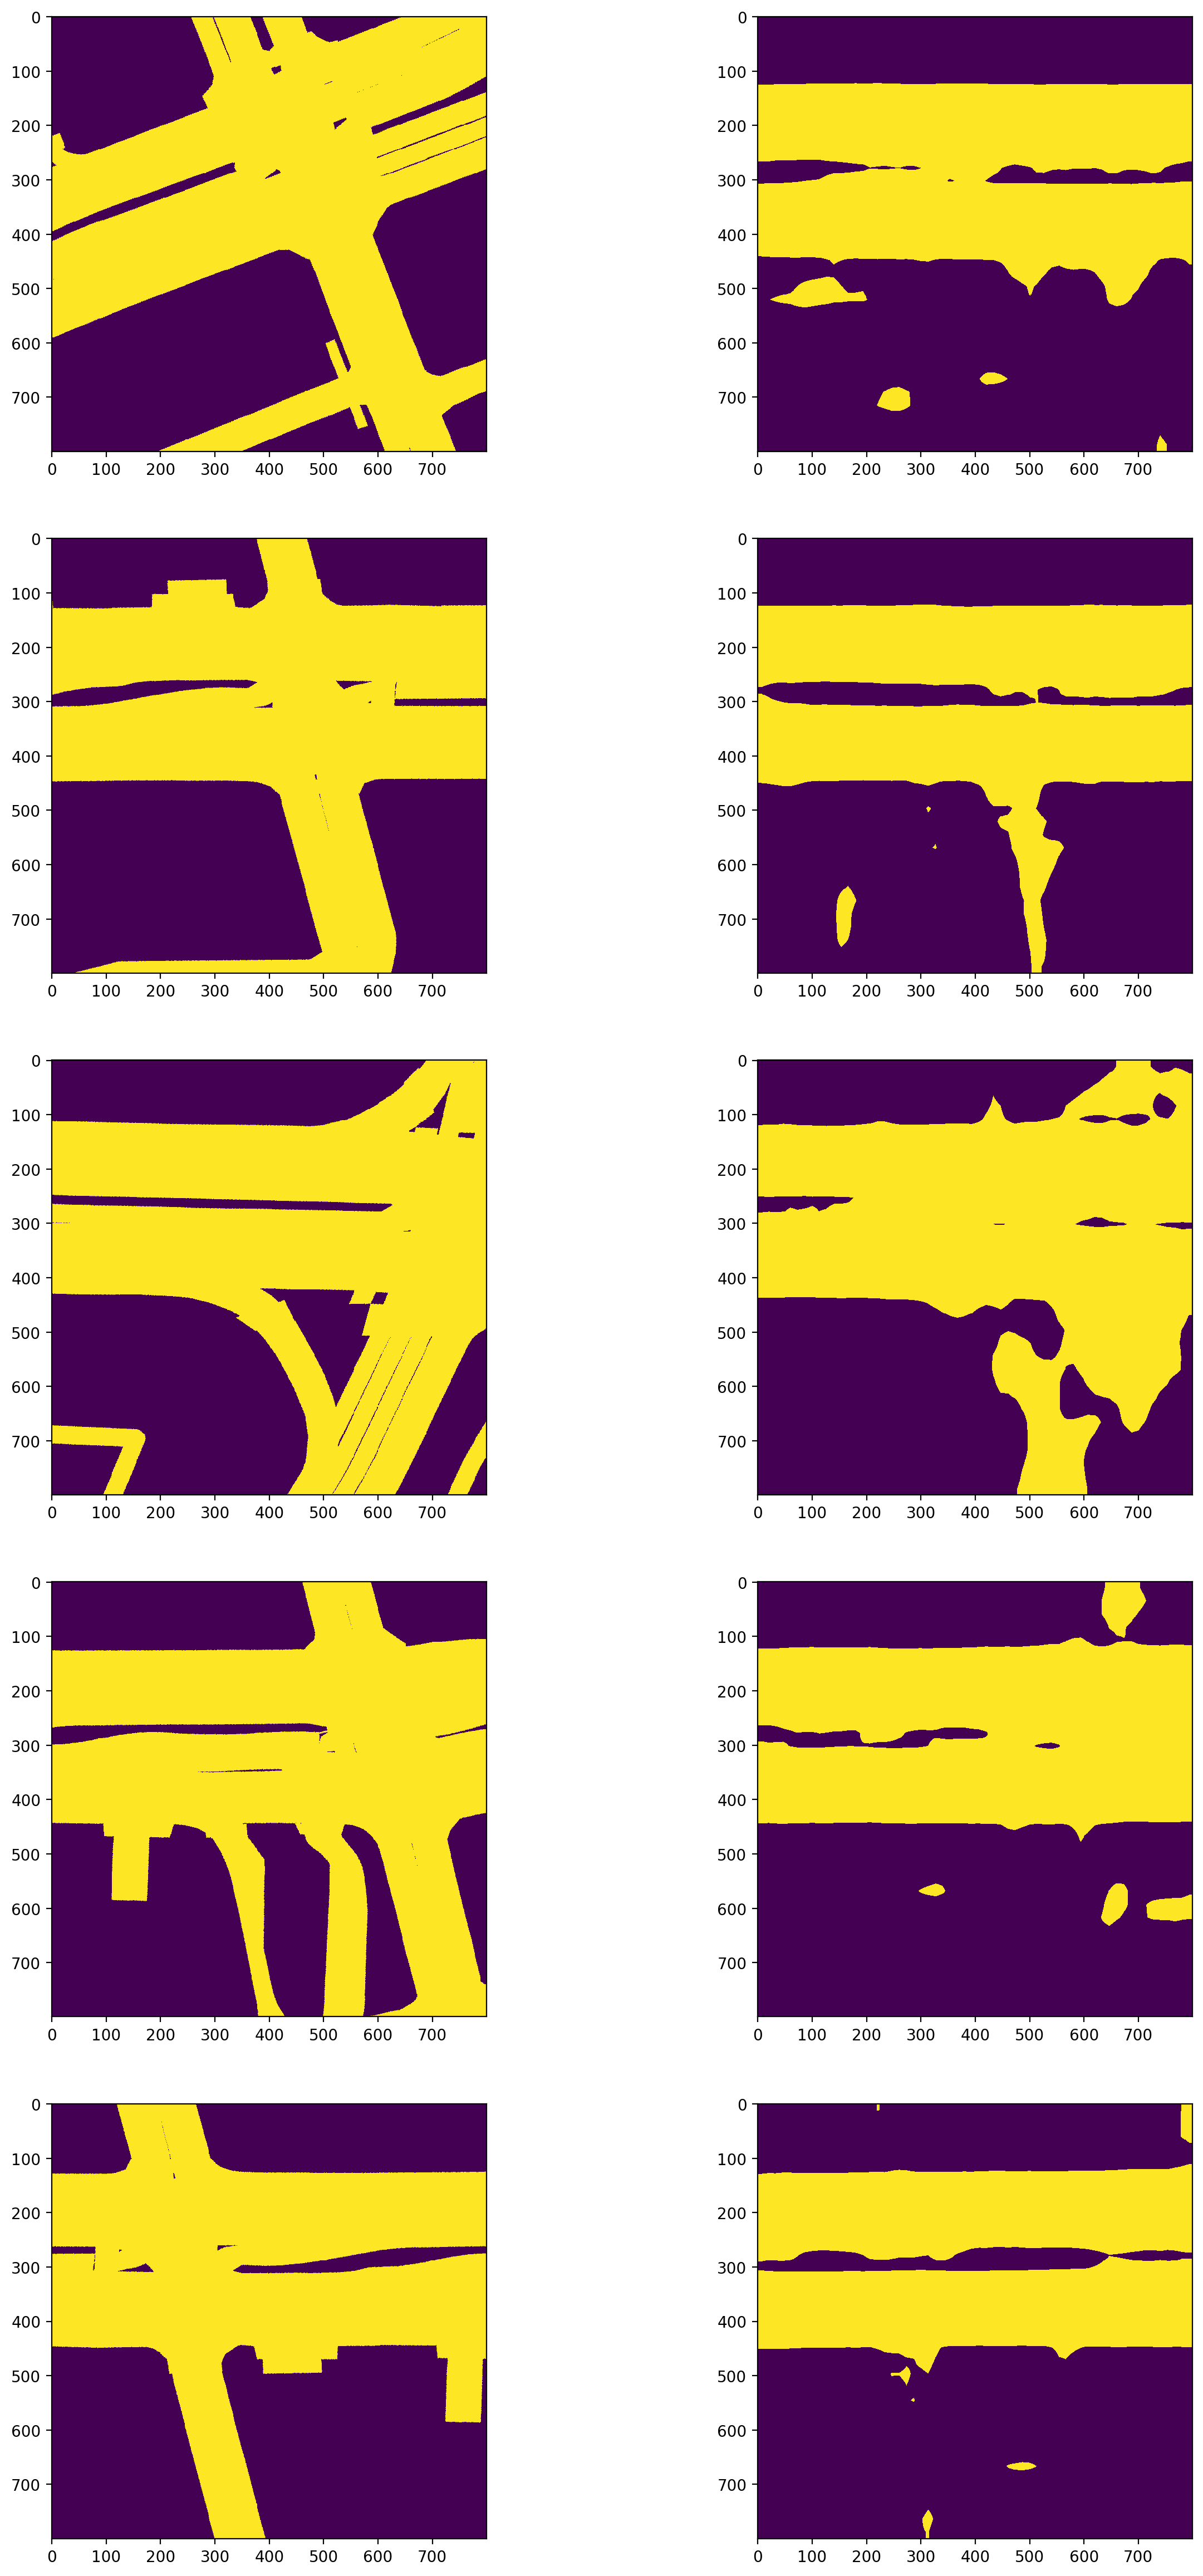

In [19]:
# Still the result after training for 40 epochs using original train dataset
fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [123, 592, 419, 322, 44]
for fig_i, i in enumerate(test_idx):
    inputs = labeled_valset[i][0].unsqueeze(0).to(device)
    
    outputs = model(inputs).cpu().squeeze().detach()
        
    ax[fig_i, 0].imshow(labeled_valset[i][2].cpu().numpy())
    
    ax[fig_i, 1].imshow((outputs>0.5).numpy())
    

Epoch 1/15
----------
current epoch dice loss is 932.9608579277992
current epoch dice is  tensor(856.5201)
Training 1 epoch takes  295.48129749298096
Epoch 2/15
----------
current epoch dice loss is 783.1476540565491
current epoch dice is  tensor(931.4263)
Training 1 epoch takes  290.50100684165955
Epoch 3/15
----------
current epoch dice loss is 672.0861468315125
current epoch dice is  tensor(986.9565)
Training 1 epoch takes  291.5731735229492
Epoch 4/15
----------
current epoch dice loss is 580.7925618290901
current epoch dice is  tensor(1032.6042)
Training 1 epoch takes  290.1720356941223
Epoch 5/15
----------
current epoch dice loss is 503.3308901786804
current epoch dice is  tensor(1071.3333)
Training 1 epoch takes  292.53566551208496
Epoch 6/15
----------
current epoch dice loss is 437.7183772325516
current epoch dice is  tensor(1104.1407)
Training 1 epoch takes  292.2247552871704
Epoch 7/15
----------
current epoch dice loss is 381.8697370290756
current epoch dice is  tensor(113

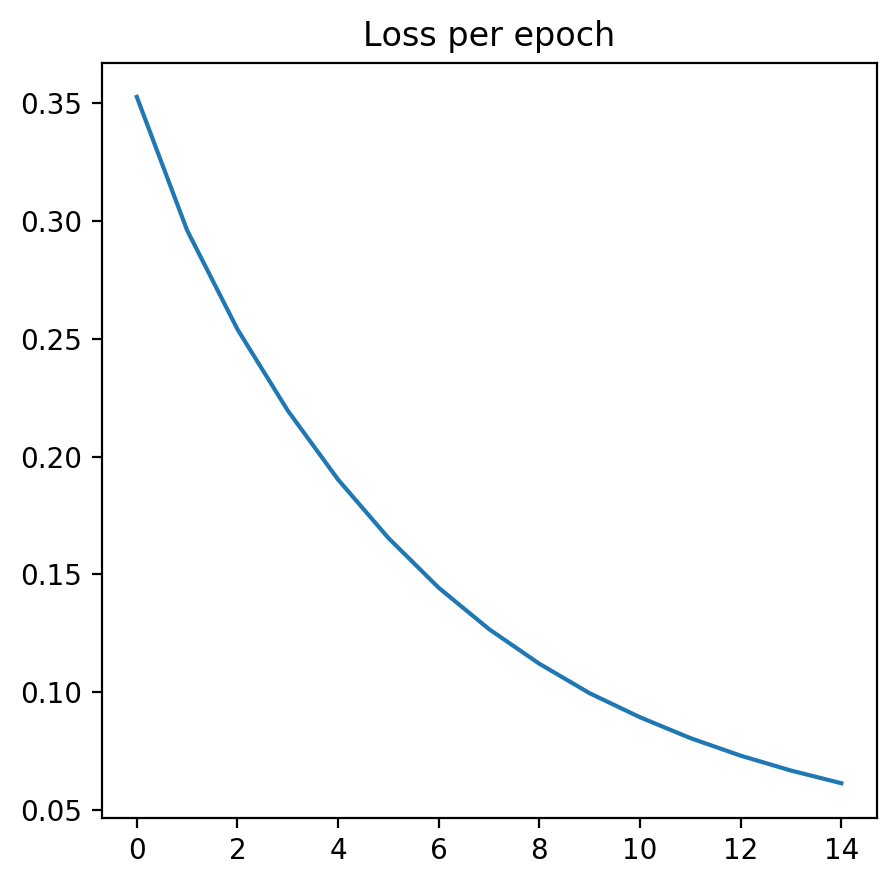

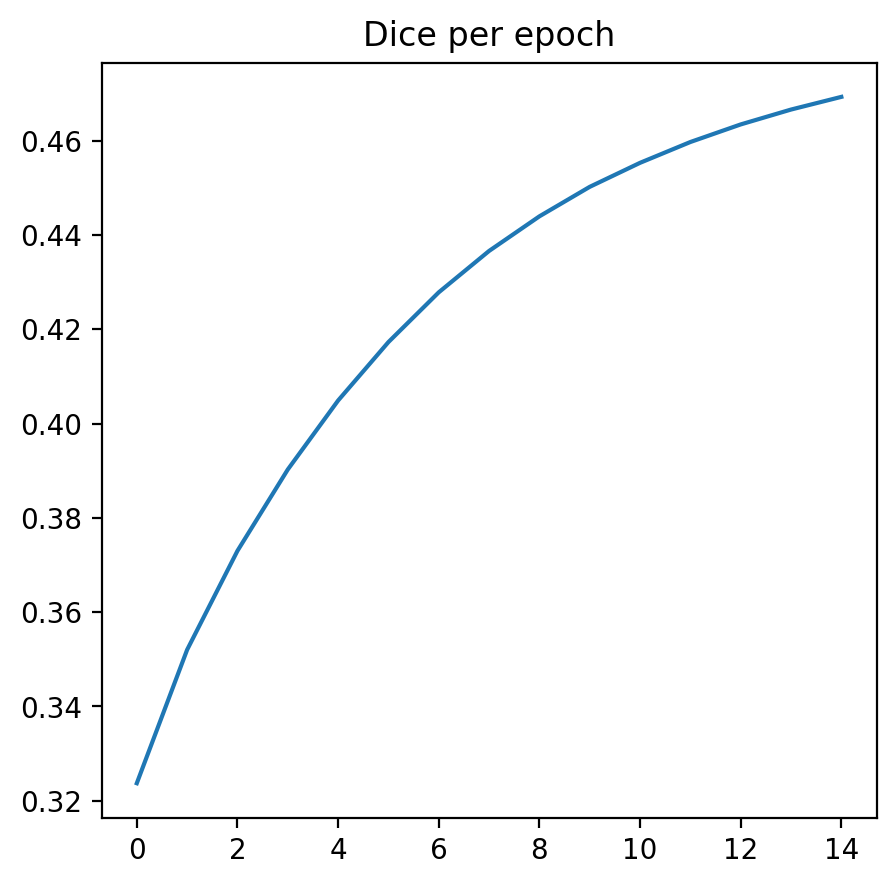

In [24]:
# Result when using all availabel scenes for training
# final average pool layer and last residual layer is removed to better preserve the resolutions
resnet_encoder1 = torchvision.models.resnet18(pretrained = False)
resnet_encoder1 = list(resnet_encoder1.children())[:-3]
resnet_encoder1 = nn.Sequential(*resnet_encoder1)
for param in resnet_encoder1.parameters():
    param.requires_grad = True
resnet_encoder1 = resnet_encoder1.to(device)
# result produced by this encoder is B x 256 x 16 x 20(from 256 x 306)

DIM1 = 16
DIM2 = 20
decoder1 = PPMBilinear(fc_dim=256)
my_model1 = vpn_model(DIM1, DIM2, resnet_encoder1, decoder1).to(device)

optimizer = torch.optim.Adam(my_model1.parameters(), lr = 1e-4)

model1, loss_dict1, dice_dict1 = train_model(my_model1, train_loader, dice_loss, optimizer, 15)


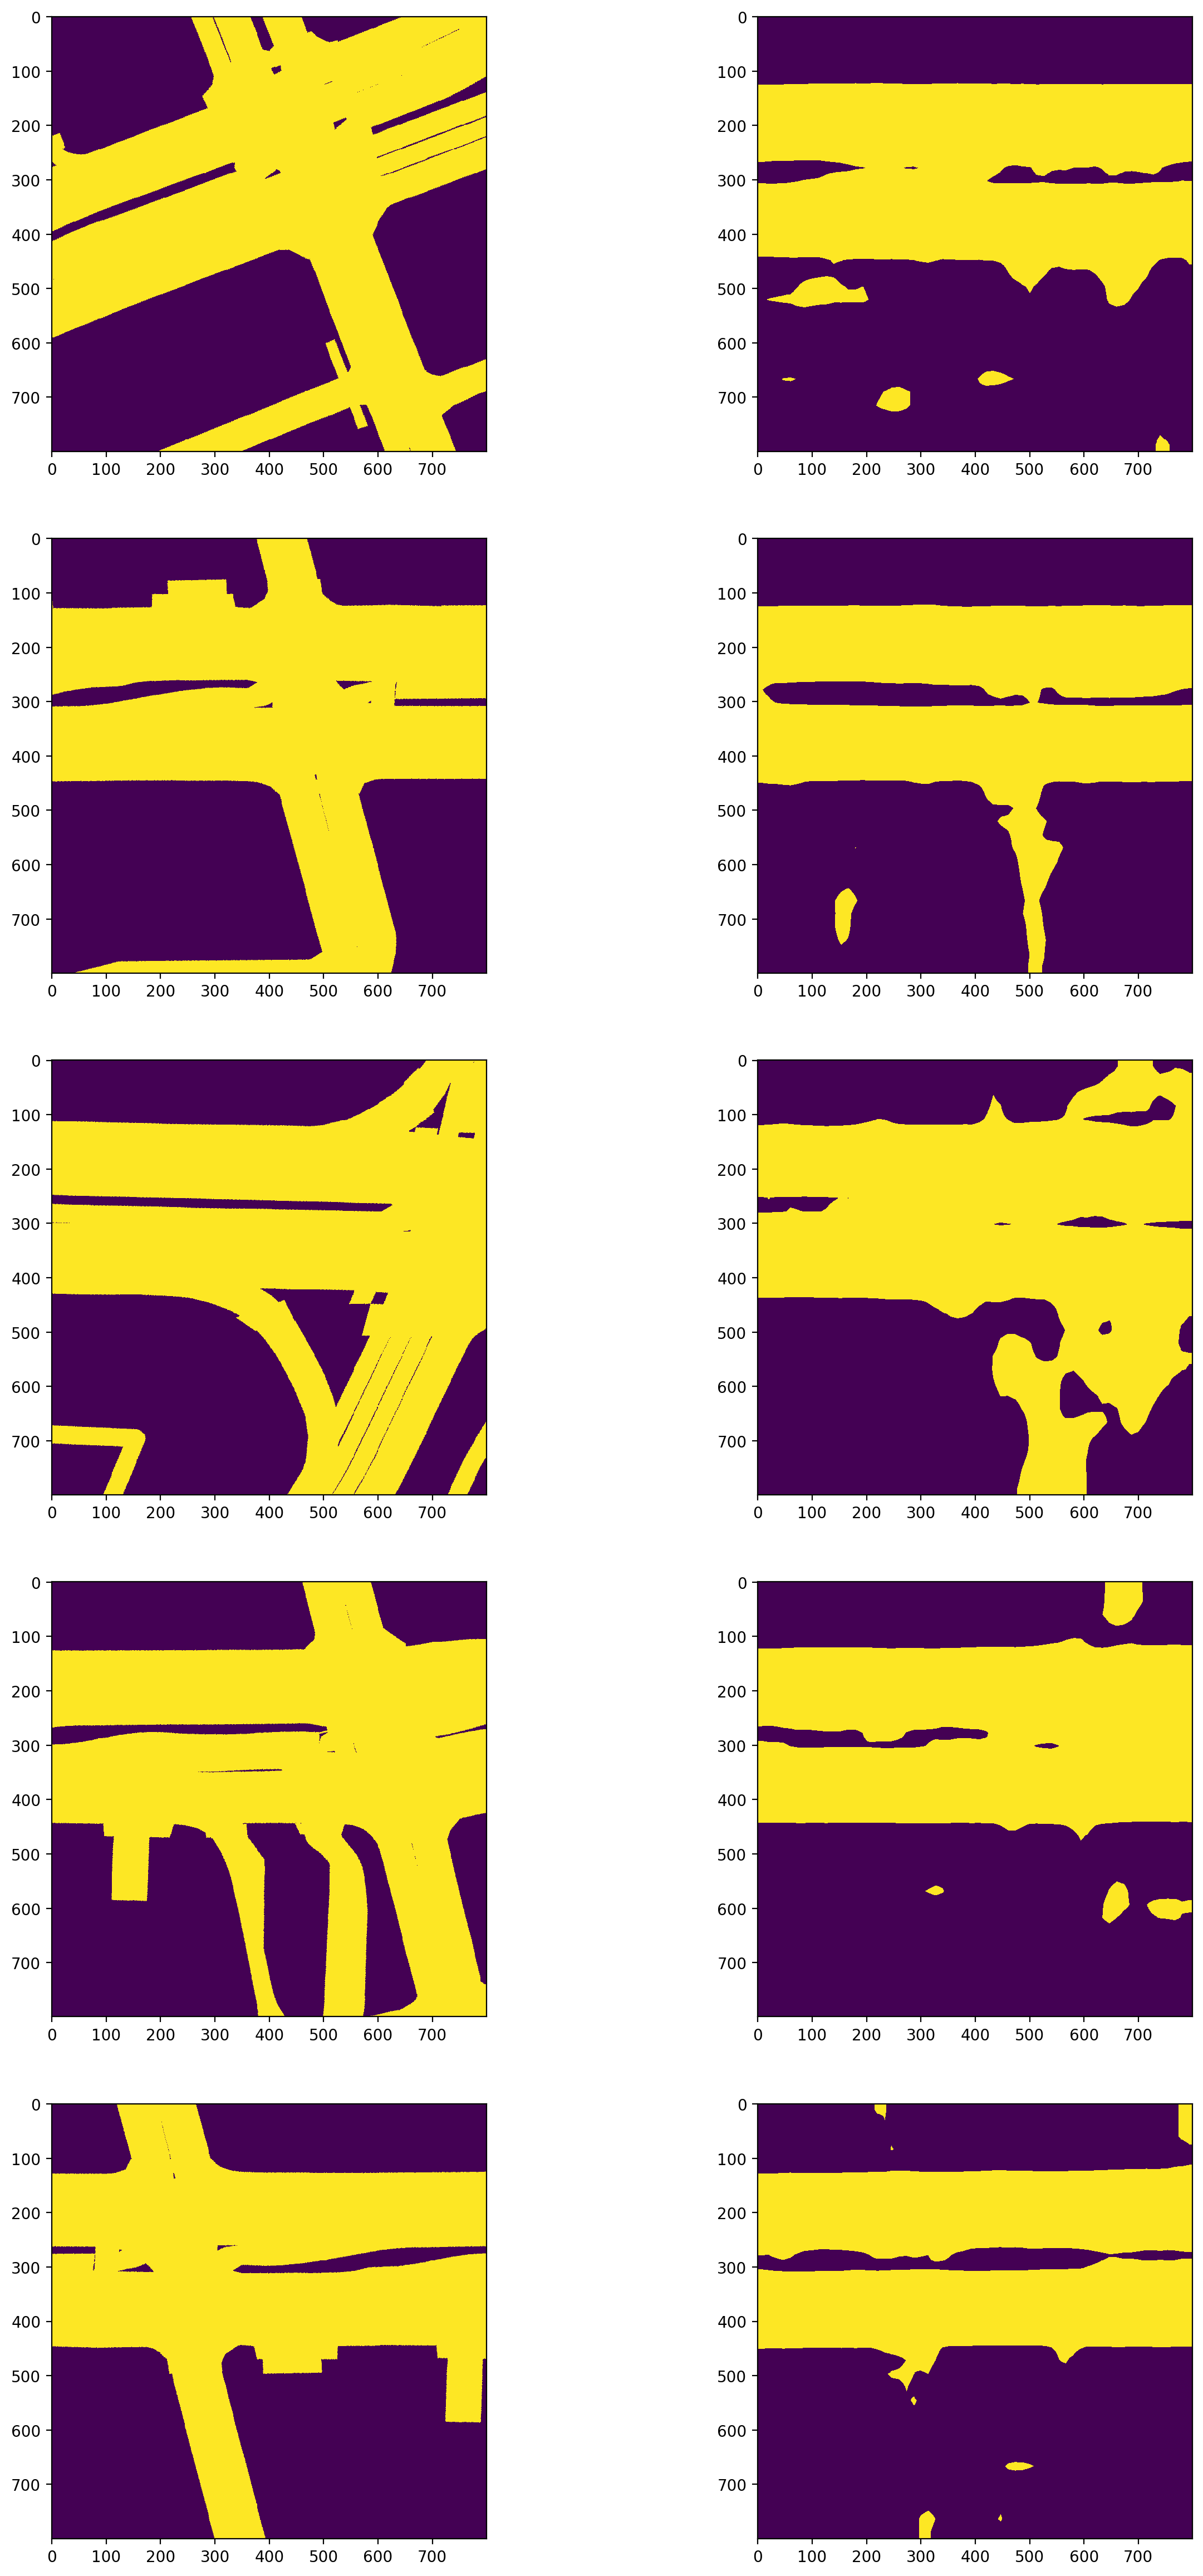

In [25]:
fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [123, 592, 419, 322, 44]
for fig_i, i in enumerate(test_idx):
    inputs = labeled_valset[i][0].unsqueeze(0).to(device)
    
    outputs = model(inputs).cpu().squeeze().detach()
        
    ax[fig_i, 0].imshow(labeled_valset[i][2].cpu().numpy())
    
    ax[fig_i, 1].imshow((outputs>0.5).numpy())
    

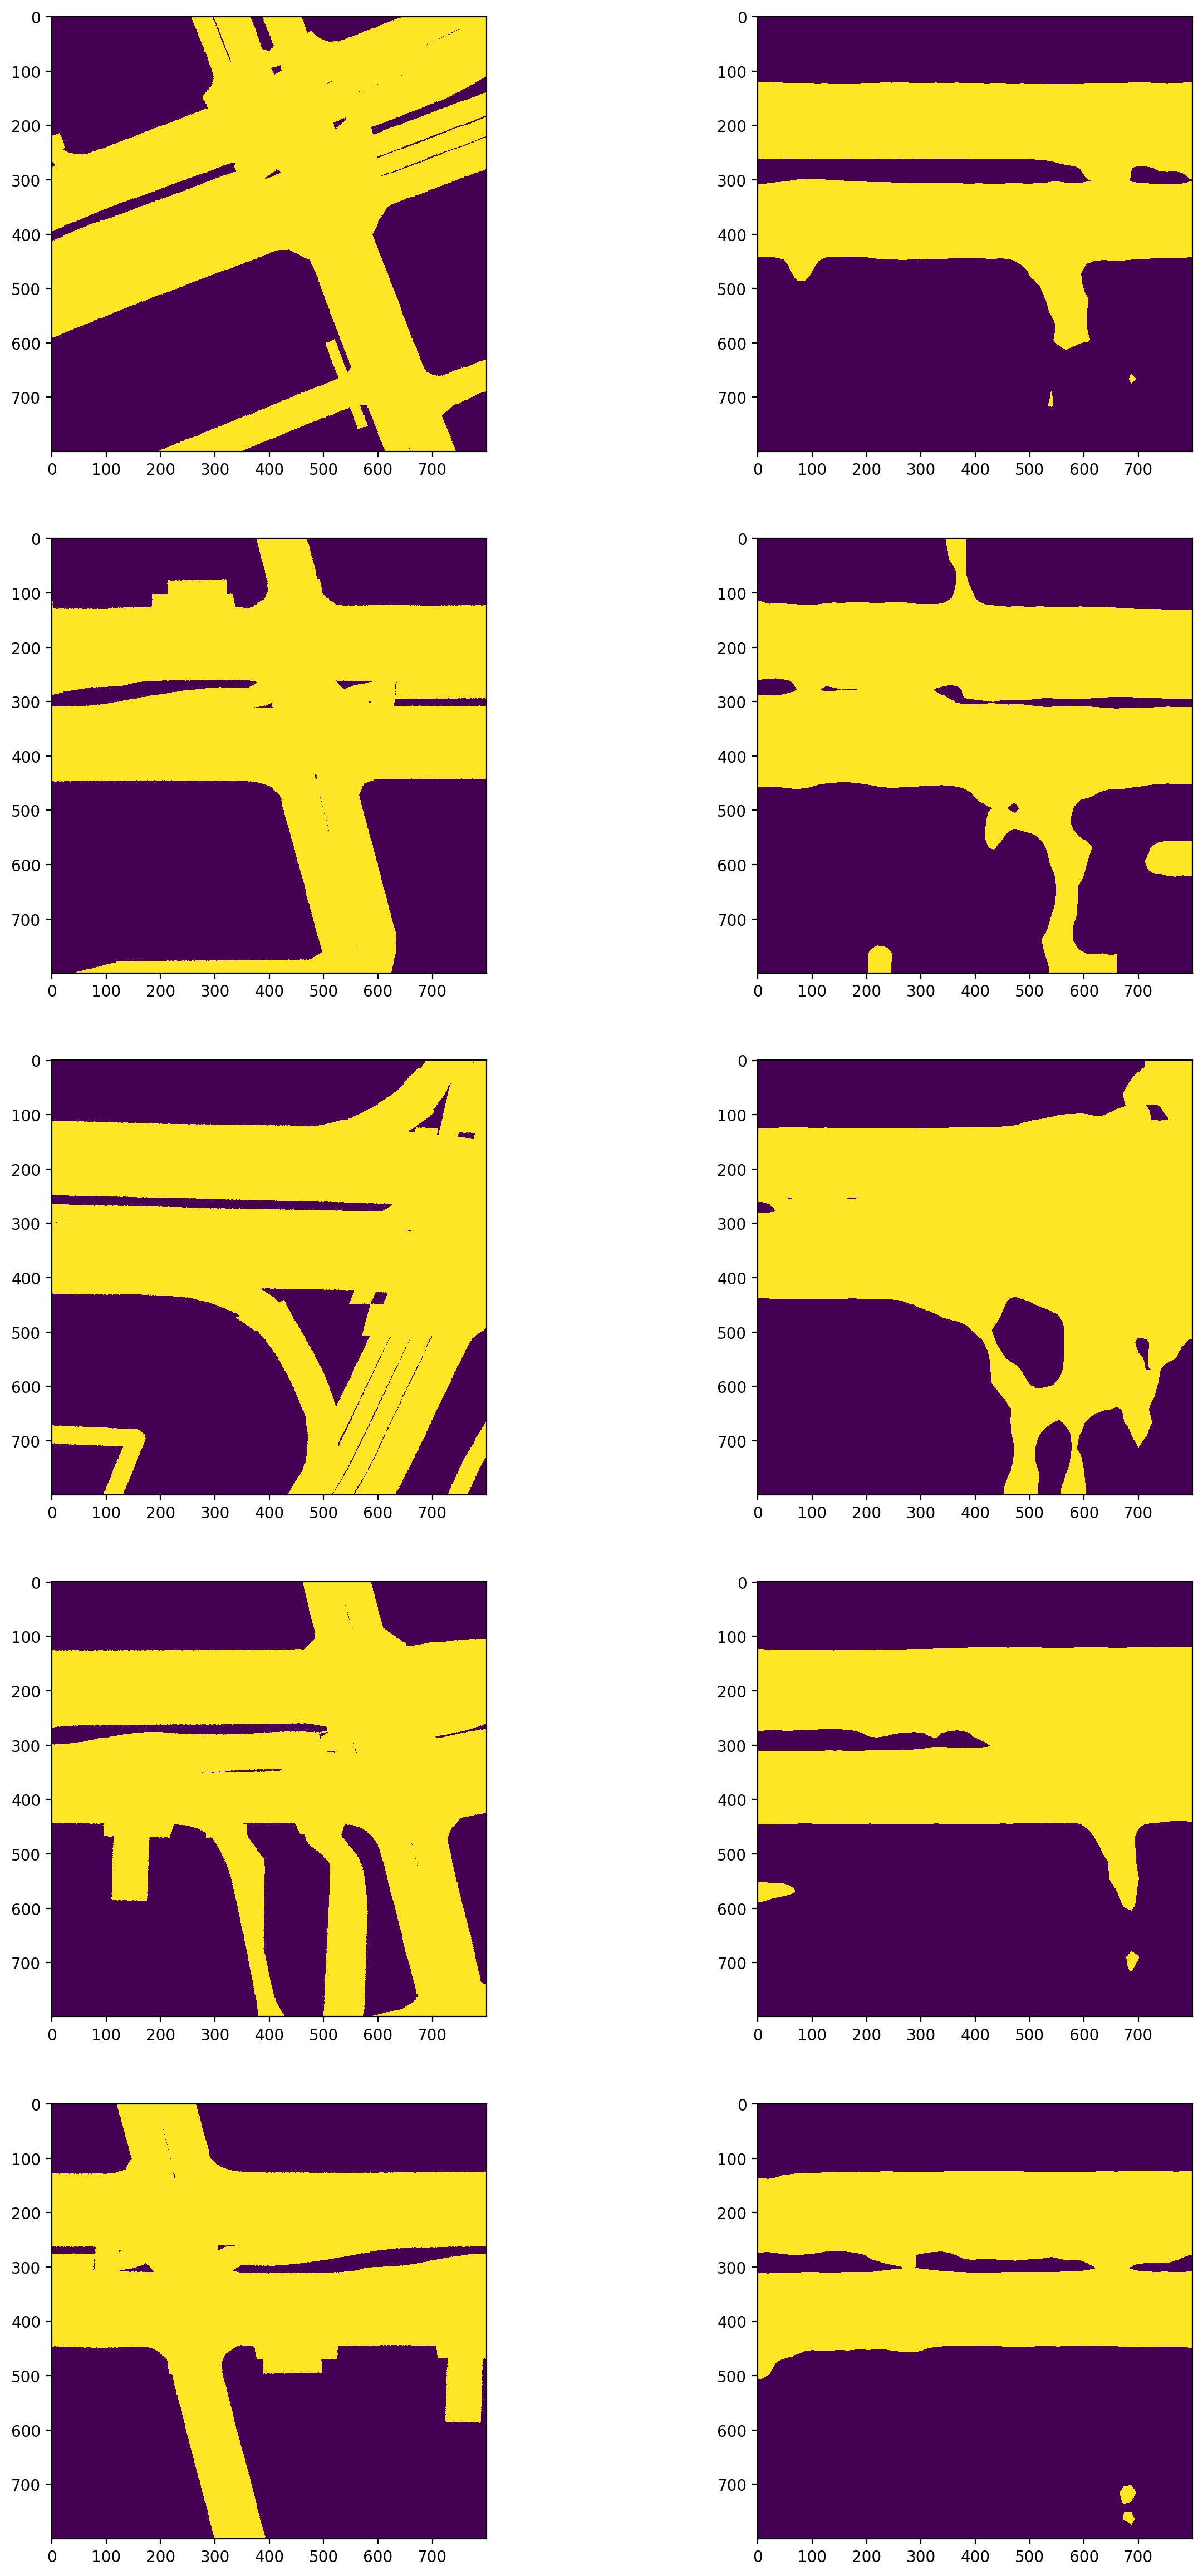

In [125]:
## This is the result after training on original train dataset for 15 epochs

fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [123, 592, 419, 322, 44]
for fig_i, i in enumerate(test_idx):
    inputs = labeled_valset[i][0].unsqueeze(0).to(device)
    
    outputs = model(inputs).cpu().squeeze().detach()
        
    ax[fig_i, 0].imshow(labeled_valset[i][2].cpu().numpy())
    
    ax[fig_i, 1].imshow((outputs>0.5).numpy())
    

In [95]:
len(labeled_valset[419][0])

6

In [117]:
labeled_valset[419][0].unsqueeze(0).shape

torch.Size([1, 6, 3, 256, 306])

In [83]:
labaled_vaset[i][0]

630

In [84]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace= True),
    )

def concat_features(feature_list):
    # print(len(feature_list))
    assert len(feature_list) == 6
    output = torch.cat([feature_list[i] for i in range(3)], dim=3)
    output1 = torch.cat([feature_list[i] for i in range(3, 6)], dim=3)
    return torch.cat([output, output1], dim=2)
    

class ResNetUNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=False)
        self.base_layers = list(self.base_model.children())
        
        # self.res_feature_list = []
        self.res_head = nn.Sequential(*self.base_layers[:3])
        self.res_up = nn.Upsample((400,400))
        
        self.layer0_1x1 = convrelu(64, 64,1,0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64,1,0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128,128,1,0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1,0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1,0)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', 
                                    align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        # self.orig_list = []
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.orig_up = nn.Upsample((800,800))
        
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Sequential(
                            nn.Conv2d(64, 1, 1),
                            nn.Sigmoid())
        
        
    def forward(self, sample_input):

        #layer0 = self.layer0(input)
        res_feature_list = []
        orig_list = []
        for i in range(6):
            res_feature_list.append(self.res_head(sample_input[i].unsqueeze(0)))
            orig_list.append(self.conv_original_size0(sample_input[i].unsqueeze(0)))
    
        layer0  = self.res_up(concat_features(res_feature_list))
        #print('The layer0 shapeis ', layer0.shape)
        
        # x_original = self.conv_original_size0
        x_original = self.orig_up(concat_features(orig_list))
        #print('The original shape is ', x_original.shape)
        
        x_original = self.conv_original_size1(x_original) # 64 x 256 x 256 
        
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3) # 512 x 8x8

        layer4 = self.layer4_1x1(layer4) # 512 x 8 x 8
        x = self.upsample(layer4) # 512 x 16 x 16
        layer3 = self.layer3_1x1(layer3) # 256 x 16 x 16
        x = torch.cat([x, layer3], dim=1) # 769 x 16 x 16
        x = self.conv_up3(x) # 512 x 16 x16

        x = self.upsample(x) # 512 x 32 x32 
        layer2 = self.layer2_1x1(layer2) # 128 x 32 x 32 
        x = torch.cat([x, layer2], dim=1) # 640x 32 x 32 
        x = self.conv_up2(x) # 256 x 32 x 32

        x = self.upsample(x) # 256 x 64 x64
        layer1 = self.layer1_1x1(layer1)# 64 x 64 x 64 
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x) # 256 x 64 x 64 

        x = self.upsample(x) # 256 x 128 x 128
        layer0 = self.layer0_1x1(layer0) # 64 x 128 x 128
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)# 128 x 128 x128

        x = self.upsample(x) # 128x 256 x 256
        x = torch.cat([x, x_original], dim=1) # (64+128) x 256 x 256
        x = self.conv_original_size2(x) # 64 x 256 x 256

        out = self.conv_last(x)

        return out   
        
        

In [87]:
unet_model = ResNetUNet2()
unet_model.load_state_dict(torch.load('/scratch/ht1162/DLSP20Dataset/res18_unet.pth'))

unet_model = unet_model.to(device)

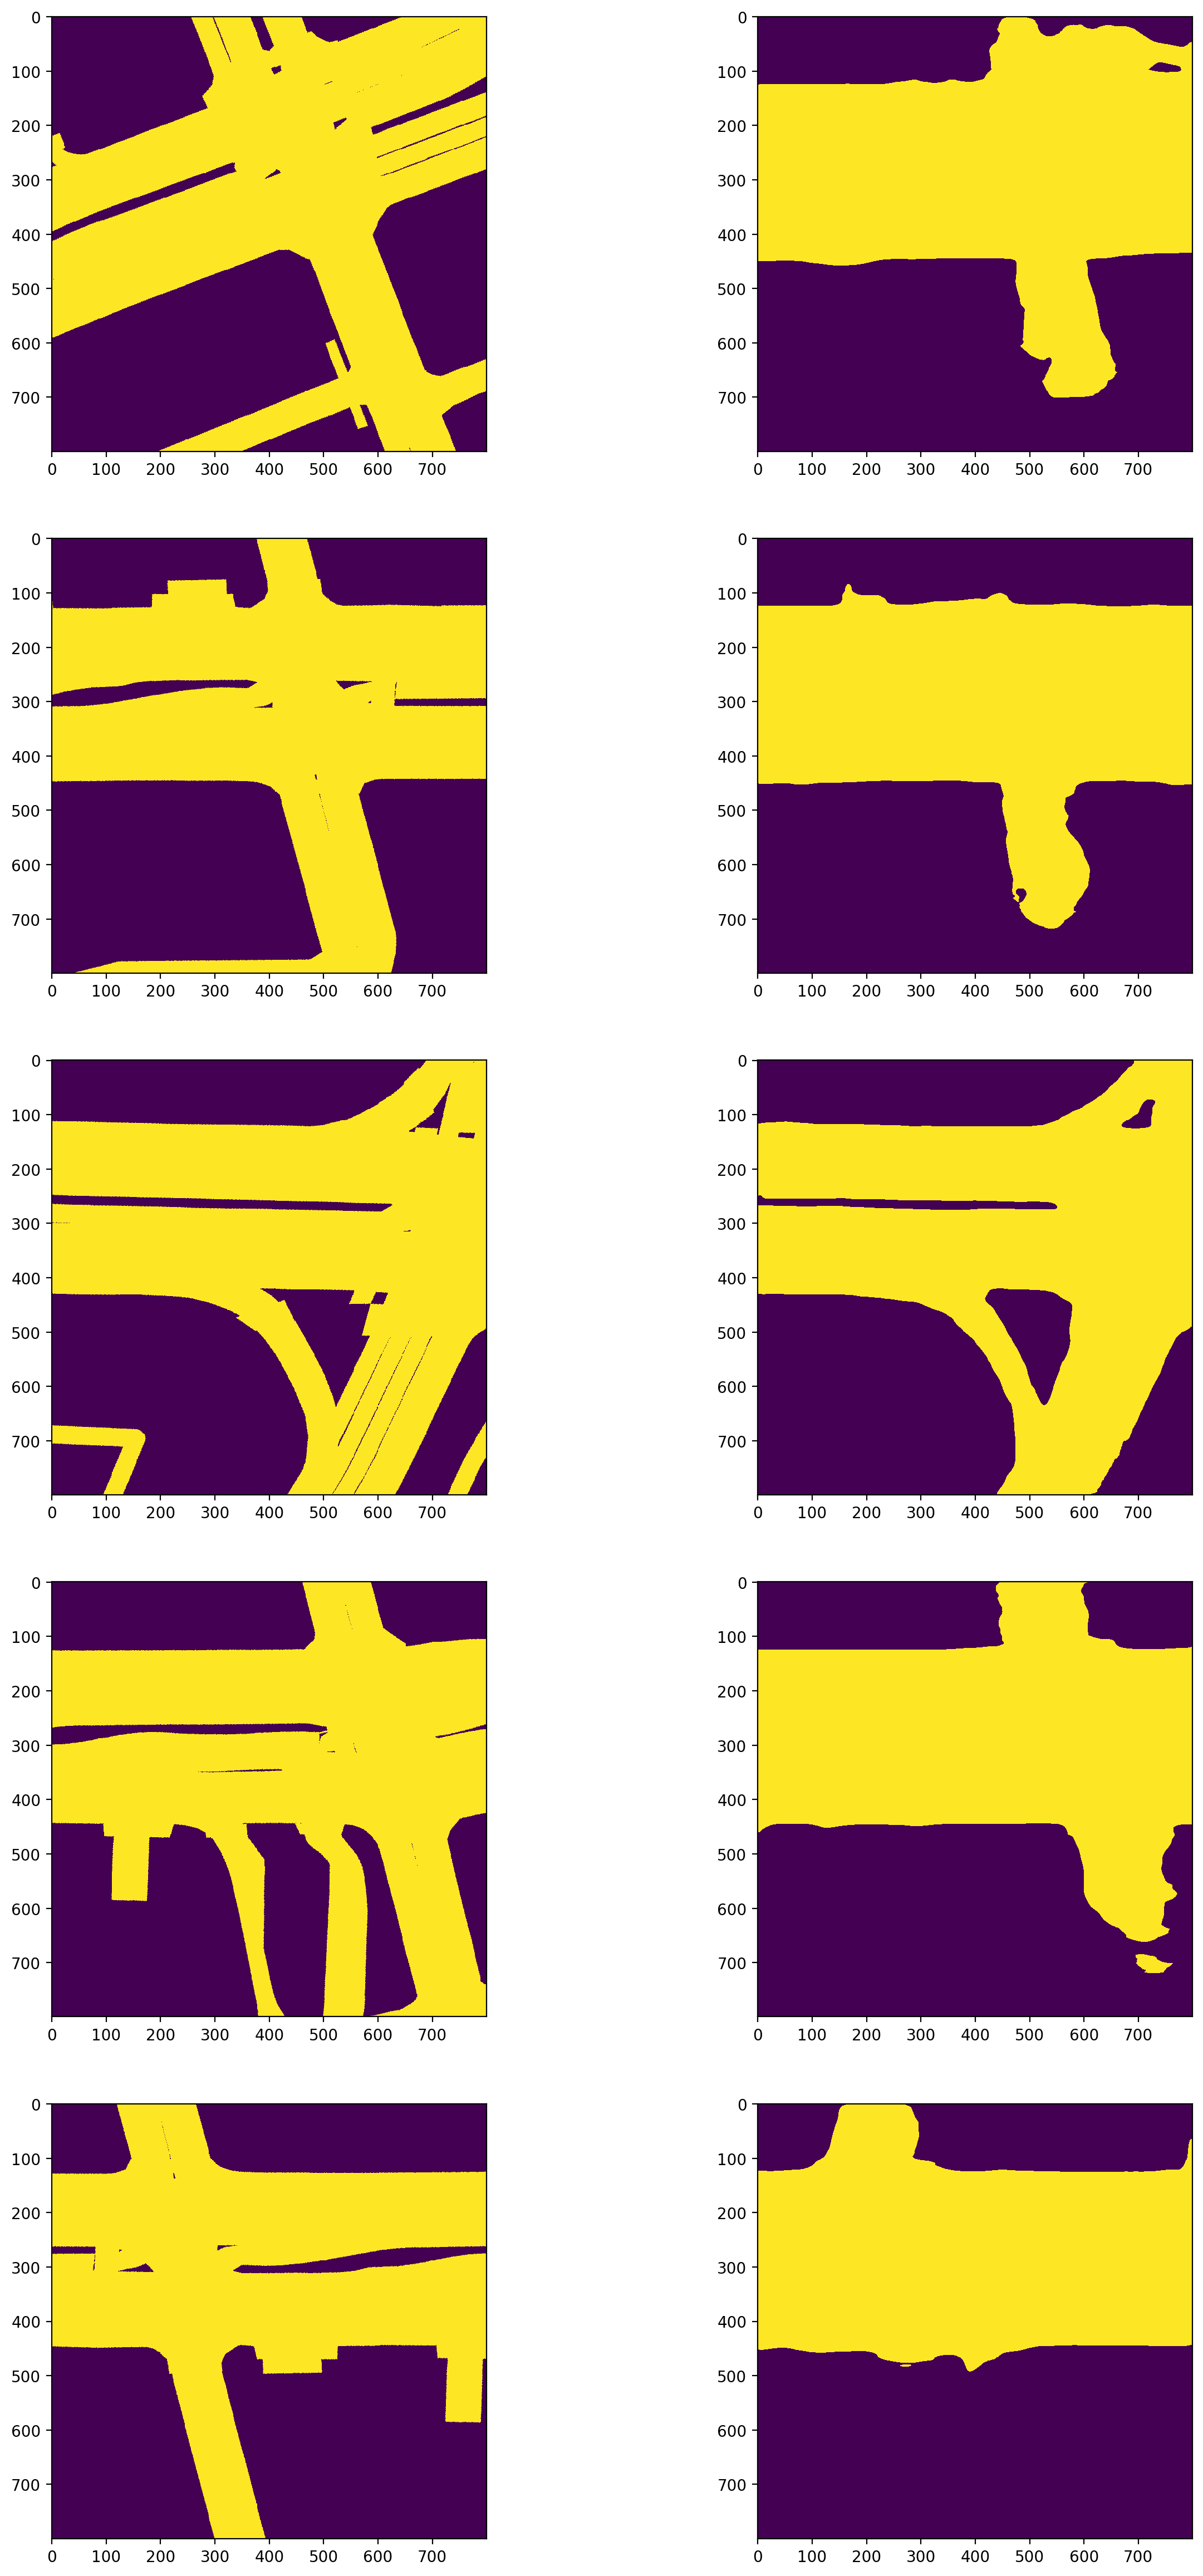

In [93]:
fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [123, 592, 419, 322, 44]
for fig_i, i in enumerate(test_idx):
    inputs = labeled_valset[i][0].cuda()
    
    outputs = unet_model(inputs).cpu().squeeze().detach()
    
    outputs = torch.rot90(outputs, -1, [0,1])
    ax[fig_i, 0].imshow(labeled_valset[i][2].cpu().numpy())
    ax[fig_i, 1].imshow((outputs>0.5).numpy())
    